**Photo replacement combining a Segmentation and a Difussion generative model**

This project combines Image Editing , Segmentation and Generation by using segmentation model and stable diffusion model

In [ ]:
#@title Demo Video
import IPython.display as ipd
html = ipd.display(ipd.HTML('<iframe width="720" height="409" src="https://www.youtube.com/embed/rLO7bdN8jOE?si=uO4O9p6IR-Xs9RgH" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

#Installing requried libraries
**regx**: regular expression library

**tqdm**: progress bar

**transormers**: from hugging face, to easily download and train models

**diffusers**: from hugging face, to easily download and use diffusion modes

**scipy**: mathiematical operations

**accelerate**: make training and inference simple and efficient

**Xformer**: Accelerate and optimize transformer

**opencv**: Library for real-time computer vision

In [ ]:
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


In [ ]:
### segmentation-anything libraries
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
# Import
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
import PIL, cv2
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt
import numpy as np
import copy
from numpy import asarray
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

**Initial parameters**

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

**Download Segmentation saved model data**
two optional links:

https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

https://github.com/facebookresearch/segment-anything

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-04-23 11:56:39--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.82, 13.35.7.50, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   117MB/s    in 25s     

2024-04-23 11:57:04 (99.1 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
# Import stabe diffusion model by diffusers from hugging face
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir ="stabilityai/stable-diffusion-2-inpainting"

#Algorithm is used during denoising process for diffusion
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, scheduler = scheduler, revision="fp16", torch_dtype = torch.float16)

pipe = pipe.to(device)

if torch.cuda.is_available():
  pipe.enable_xformers_memory_efficient_attention()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


#Use segmenation-anything to inpaint image

## Prepare input images

**Download Image**

image loaded.
Source image size:(2787, 4180)
Target image size:(400, 400)


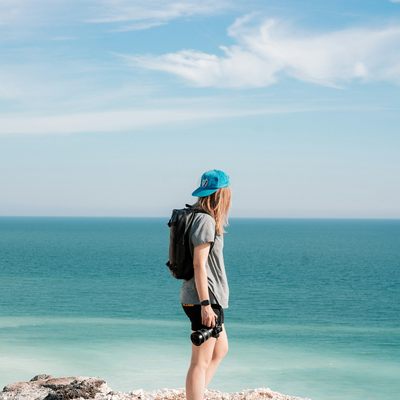

In [ ]:
import requests
from google.colab import files

target_width = 400 #@param{type:"integer",min:64, max:512}
target_height = 400 #@param{type:"integer",min:64, max:512}
input_image_path = "aaa.jpg"

#@title Image Loader { run: "auto" }
choice = "URL" #@param ["Upload", "URL"] {type:"string"}
input_image_path = "https://images.unsplash.com/photo-1624530461693-acc3f4f6c746?q=80&w=2787&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" #@param {type:"string"}

def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        image_data = BytesIO(response.content)
        image = Image.open(image_data).convert('RGB')
        return image
    else:
        raise Exception("Failed to retrieve image. Status code:", response.status_code)

def load_image_from_upload():
    print("Please upload your image file:")
    uploaded = files.upload()
    if uploaded:
        image_name = next(iter(uploaded))
        image_data = BytesIO(uploaded[image_name])
        image = Image.open(image_data).convert('RGB')

        return image
    else:
        raise Exception("No file uploaded.")

if choice == "Upload":
    source_image = load_image_from_upload()
elif choice == "URL" and input_image_path:
    source_image = load_image_from_url(input_image_path)
else:
    print("Please enter a valid image URL in the form input or upload an image.")

if 'source_image' in locals():
    print("image loaded.")
else:
    print("No image loaded.")
width, height = source_image.size
print(f"Source image size:{source_image.size}")

def resize_and_crop(image, target_width, target_height):
    # Calculate target ratio
    target_ratio = target_width / target_height
    source_ratio = image.width / image.height

    if source_ratio > target_ratio:
        # source is wider, scale based on height
        scale_height = target_height
        scale_width = int(scale_height * source_ratio)
    else:
        # source is higher, scale based on width
        scale_width = target_width
        scale_height = int(scale_width / source_ratio)

    image = image.resize((scale_width, scale_height), Image.LANCZOS)

    # calculation the crop aera
    left = (scale_width - target_width) / 2
    top = (scale_height - target_height) / 2
    right = (scale_width + target_width) / 2
    bottom = (scale_height + target_height) / 2
    image = image.crop((left, top, right, bottom))
    return image

source_image = resize_and_crop(source_image, target_width, target_height)
print(f"Target image size:{source_image.size}")
segmentation_image = asarray(source_image)
display(source_image)


**Segment image**

In [ ]:
# Initialize Segment Model
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint = sam_checkpoint)
sam.to(device)

#segment the image
mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    pred_iou_thresh = 0.99,
    stability_score_thresh = 0.92,
    crop_n_layers = 1,
    crop_n_points_downscale_factor = 2,
    min_mask_region_area = 100,
)

In [ ]:
masks = mask_generator.generate(segmentation_image)
print(f"Number of masks generated: {len(masks)}")

Number of masks generated: 6


In [ ]:
### Declare function to visualize the masks generated together with a number that identifies each of them

def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')


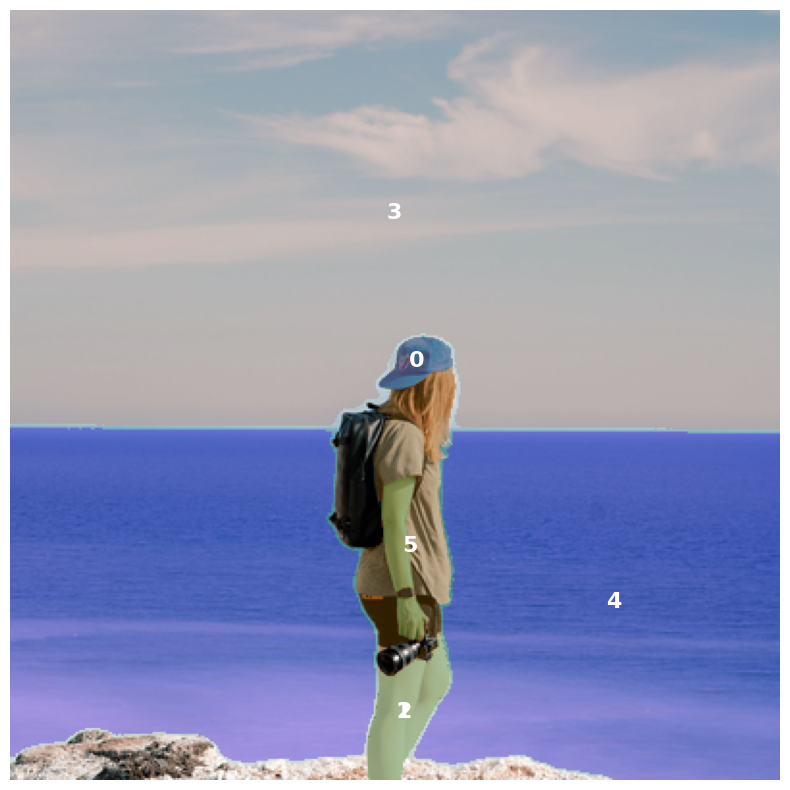

In [ ]:
#Display masks with a number
plt.figure(figsize=(10,10))
plt.imshow(source_image)
show_anns(masks)
plt.axis('off')
plt.show()

**Decide which mask will be used to inpainting with**

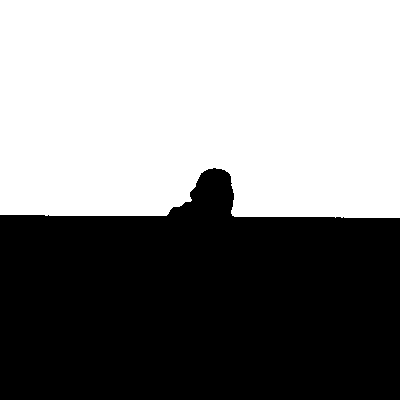

(400, 400)


In [ ]:
#@title Choose mask used for segmentation
def dilate_mask(mask, kernel_size=5, iterations=1):

    if mask is None or mask.size == 0:
        raise ValueError("Input mask is empty.")

    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=iterations)
    return dilated_mask

mask_index = 3 #@param {type:"slider", min:0, max:10, step:1}

if not (mask_index < len(masks)):
  print("Warning: Parameter out of bounds. Index should be equal less then{len(masks)}")
segmentation_mask = masks[mask_index]['segmentation']
stable_diffusion_mask = PIL.Image.fromarray(segmentation_mask)


dilated_scale = 1 #@param {type:"slider", min:1, max:10, step:1}
if dilated_scale >1 :
  dilated_mask_cv = dilate_mask(segmentation_mask, kernel_size=5*dilated_scale, iterations=2)
  # Convert back to PIL format from opencv format
  stable_diffusion_mask = Image.fromarray(dilated_mask_cv.astype(bool))

display(stable_diffusion_mask)
print(segmentation_mask.shape)

## Use stable diffusion to inpaint image according to the mask

In [ ]:
# Stepup transformation prompts
manual_seed = 10
num_images_per_prompt = 3
num_inference_steps = 30
guide_scale = 12.0
inpainting_prompts = ["cloudy", "flowers flying in sky","rainbow in the sky"]
generator = torch.Generator(device).manual_seed(manual_seed)
encoded_images = []


for prompt in inpainting_prompts:
    # Generate amount of pictures accroding to the number of prompts
    for _ in range(num_images_per_prompt):
        image = pipe(prompt=prompt,
                     guidance_scale=guide_scale,
                     num_inference_steps=num_inference_steps,
                     generator=generator,
                     image=source_image,
                     mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# used for draw the results of images on grid
def create_image_grid(images, prompts, image_size=(2, 2)):
    num_prompts = len(prompts)
    images_per_prompt = len(images) // num_prompts

    images = copy.copy(images)

    if torch.is_tensor(images):
        images = [to_pil_image(torch.sigmoid(img)) for img in images]

    fig_width = image_size[1] * (images_per_prompt + 1)
    fig_height = image_size[0] * num_prompts
    fig = plt.figure(figsize=(fig_width, fig_height))

    for i, prompt in enumerate(prompts):
        # add prompts on left
        fig.text(0, 1-(i+0.5)/num_prompts, prompt, va='center', ha='right', fontsize=12)

        for j in range(images_per_prompt):
            idx = i * images_per_prompt + j  # index of current pic
            img = images[idx]
            ax = fig.add_subplot(num_prompts, images_per_prompt, i * images_per_prompt + j + 1)
            ax.imshow(img, cmap='gray')
            ax.axis('off')

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.show()

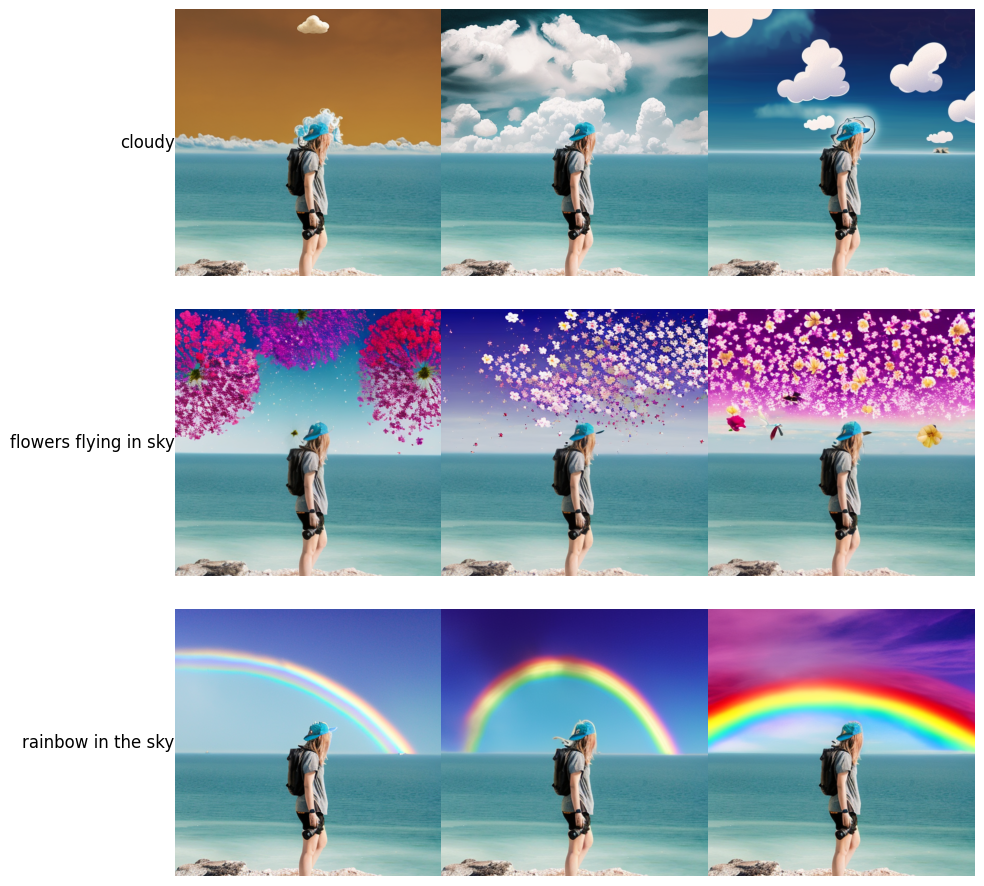

In [ ]:
create_image_grid(encoded_images, inpainting_prompts,(3,2))

# Make it Fun

##1.Choose your mask

###Show the mask

image loaded.
Source image size:(2940, 1960)
Target image size:(400, 400)


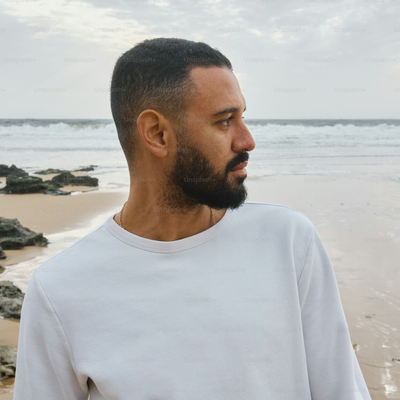

Number of masks generated: 8


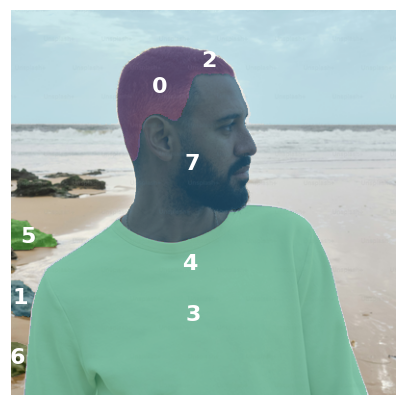

In [ ]:
#@title Download file for segmentation
target_width = 400 #@param{type:"integer",min:64, max:512}
target_height = 400 #@param{type:"integer",min:64, max:512}
input_image_path = "aaa.jpg"

#@title Image Loader { run: "auto" }
choice = "URL" #@param ["Upload", "URL"] {type:"string"}
input_image_path = "https://plus.unsplash.com/premium_photo-1675129779582-d84b954f2397?q=80&w=2940&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" #@param {type:"string"}

if choice == "Upload":
    source_image = load_image_from_upload()
elif choice == "URL" and input_image_path:
    source_image = load_image_from_url(input_image_path)
else:
    print("Please enter a valid image URL in the form input or upload an image.")

if 'source_image' in locals():
    print("image loaded.")
else:
    print("No image loaded.")
width, height = source_image.size
print(f"Source image size:{source_image.size}")
source_image = resize_and_crop(source_image, target_width, target_height)
print(f"Target image size:{source_image.size}")
segmentation_image = asarray(source_image)
display(source_image)

#segment file
masks = mask_generator.generate(segmentation_image)
print(f"Number of masks generated: {len(masks)}")

plt.figure(figsize=(5,5))
plt.imshow(source_image)
show_anns(masks)
plt.axis('off')
plt.show()

###Choose the mask

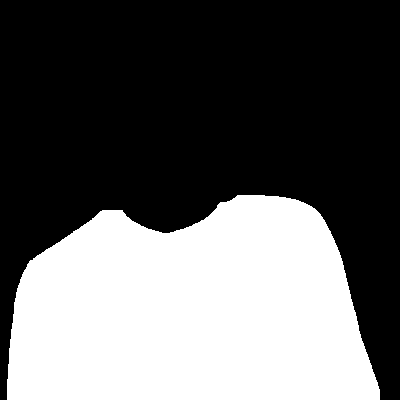

In [ ]:
mask_index = 3 #@param {type:"slider", min:0, max:10, step:1}

if not (mask_index < len(masks)):
  print("Warning: Parameter out of bounds. Index should be equal less then{len(masks)}")
segmentation_mask = masks[mask_index]['segmentation']
stable_diffusion_mask = PIL.Image.fromarray(segmentation_mask)
dilated_scale = 2 #@param {type:"slider", min:1, max:10, step:1}
if dilated_scale >1 :
  dilated_mask_cv = dilate_mask(segmentation_mask, kernel_size=5*dilated_scale, iterations=2)
  # 将OpenCV图像格式转换回PIL图像
  stable_diffusion_mask = Image.fromarray(dilated_mask_cv.astype(bool))
display(stable_diffusion_mask)



## 2.Inpaint the image

In [ ]:
#Initialize parameters
num_images_per_prompt = 3
encoded_images = []

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

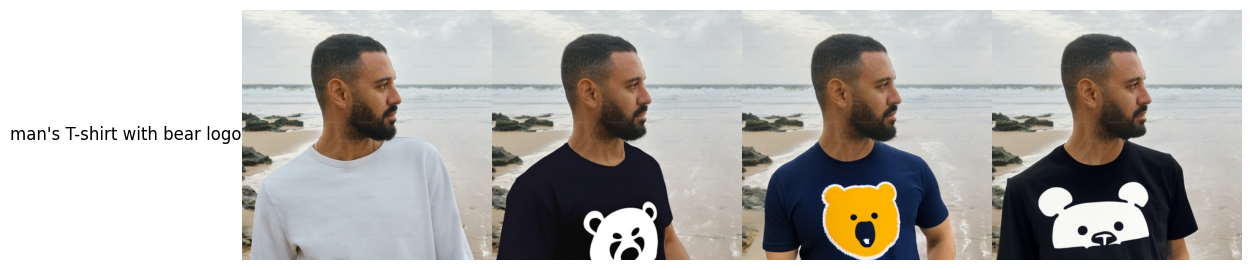

In [ ]:

num_inference_steps = 40 #@param {type:"slider", min:10, max:50, step:10}
guidance_scale = 13 #@param {type:"slider", min:1, max:20, step:1}
inpainting_prompt ="man's T-shirt with bear logo" #@param{type:"string"}
sourceimage_index = 0 #@param {type:"slider", min:0, max:3, step:1}
my_source_image = source_image
if sourceimage_index > 0 and len(encoded_images)> 0:
  my_source_image = encoded_images[sourceimage_index]
encoded_images=[]
encoded_images.append(source_image)
for _ in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompt,
                     guidance_scale=guidance_scale,
                     num_inference_steps=num_inference_steps,
                    #  generator=generator,
                     image=my_source_image,
                     mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)
create_image_grid(encoded_images, [inpainting_prompt],(3,2))

**Save file**

In [ ]:
def save_pil_image(image, file_path):
    """
    Save a PIL Image to a specified file path.

    Args:
    image (PIL.Image): The PIL Image object to save.
    file_path (str): The path to save the image file, including the filename and extension.

    Returns:
    None
    """
    # Ensure the directory exists; if not, create it
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the image
    image.save(file_path)
path = 'out/image.png'
save_index = 2
save_pil_image(encoded_images[save_index], path)

# Use prompt to segment image automatically

###Import Clip and ClipSeg repositories

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git
!git clone https://github.com/timojl/clipseg

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.25.post1 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.
Cloning into 'clipseg'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 232 (delta 74), reused 61 (delta 58), pack-reused 142
Receiving objects: 100% (232/232), 1.40 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [ ]:
original_dir = %pwd
%cd clipseg

/content/clipseg


In [ ]:
#download the pre-trained weights for the clipseg model
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

--2024-04-23 12:01:49--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [      <=>           ]   9.68M  1.87MB/s    in 6.2s    

2024-04-23 12:01:57 (1.55 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [ ]:
#import clip
import clip
from models.clipseg import CLIPDensePredT

#load the model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict= False);

100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 95.9MiB/s]


###Download Image

image loaded.
Source image size:(2940, 1960)
Target image size:(400, 400)


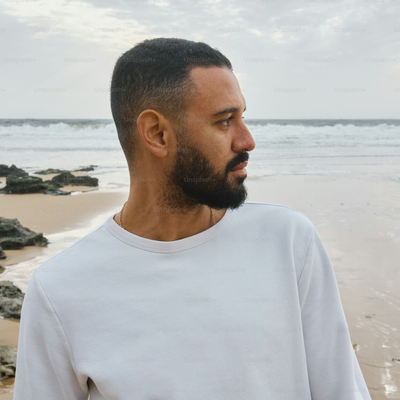

In [ ]:
#@title Download file for segmentation
target_width = 400 #@param{type:"integer",min:64, max:512}
target_height = 400 #@param{type:"integer",min:64, max:512}
input_image_path = "aaa.jpg"

#@title Image Loader { run: "auto" }
choice = "URL" #@param ["Upload", "URL"] {type:"string"}
input_image_path = "https://plus.unsplash.com/premium_photo-1675129779582-d84b954f2397?q=80&w=2940&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" #@param {type:"string"}

if choice == "Upload":
    source_image = load_image_from_upload()
elif choice == "URL" and input_image_path:
    source_image = load_image_from_url(input_image_path)
else:
    print("Please enter a valid image URL in the form input or upload an image.")

if 'source_image' in locals():
    print("image loaded.")
else:
    print("No image loaded.")
width, height = source_image.size
print(f"Source image size:{source_image.size}")
source_image = resize_and_crop(source_image, target_width, target_height)
print(f"Target image size:{source_image.size}")
segmentation_image = asarray(source_image)
display(source_image)



###Create mask by words

In [ ]:
#Create masks for the parts of image to be identified
prompts = ['a lake','a shirt','a hair']
transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),])
tensor_image = transform(source_image).unsqueeze(0)
print(tensor_image.shape)
with torch.no_grad():
  preds= model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]

torch.Size([1, 3, 400, 400])


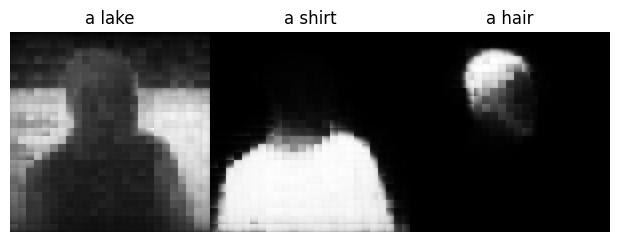

In [ ]:
def create_image_grid_horizon(images, prompts, image_size=(2, 2)):
    assert len(images) == len(prompts), "The number of images must be equal to the number of prompts"

    # convert to PIL image from tensor
    if torch.is_tensor(images[0]):
        images = [to_pil_image(torch.sigmoid(img)) for img in images]

    # Caluculate the size of canvas
    fig_width = image_size[1] * len(images)
    fig_height = image_size[0] + 0.5
    fig, axes = plt.subplots(1, len(images), figsize=(fig_width, fig_height))


    if len(images) == 1:
        axes = [axes]

    # Add title on top of image
    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img, cmap='gray')
        ax.set_title(prompt, fontsize=12)
        ax.axis('off')  # 隐藏坐标轴

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.show()
create_image_grid_horizon(preds,prompts)

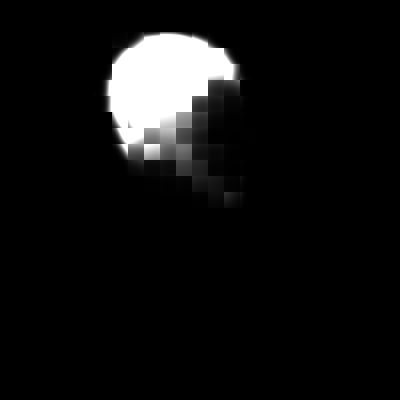

In [ ]:
#choose mask
mask_index = 2 #@param {type:"slider", min:0, max:5, step:1}
mask_intensity = 2.8 #@param {type:"slider", min:1, max:3, step:0.2}
#Normalize mask values by computing the area under Gaussian probability density function, calculating the cumulative distribution with ndtr
processed_mask = torch.special.ndtr(preds[mask_index][0])*mask_intensity
processed_mask = processed_mask.clip(0,1)
stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)

###Inpaint

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

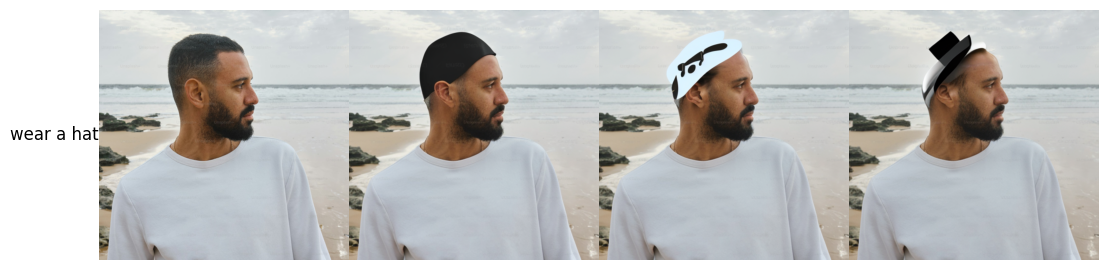

In [ ]:
num_inference_steps = 40 #@param {type:"slider", min:10, max:50, step:10}
guidance_scale = 13 #@param {type:"slider", min:1, max:20, step:1}
inpainting_prompt ="wear a hat" #@param{type:"string"}
sourceimage_index = 0 #@param {type:"slider", min:0, max:3, step:1}
my_source_image = source_image
if sourceimage_index > 0 and len(encoded_images)> 0:
  my_source_image = encoded_images[sourceimage_index]
encoded_images=[]
encoded_images.append(source_image)
for _ in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompt,
                     guidance_scale=guidance_scale,
                     num_inference_steps=num_inference_steps,
                    #  generator=generator,
                     image=my_source_image,
                     mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)
create_image_grid(encoded_images, [inpainting_prompt],(3,2))

#Make it fun for automatic inpainting

image loaded.
Source image size:(2940, 1960)
Target image size:(400, 400)


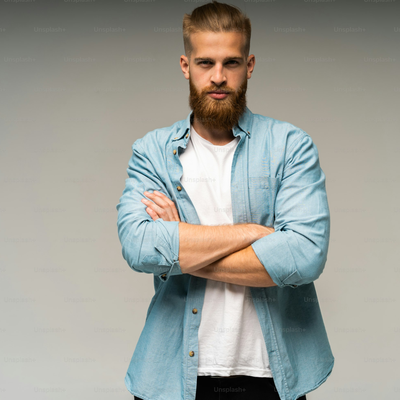

In [ ]:
#@title Download file for segmentation
target_width = 400 #@param{type:"integer",min:64, max:512}
target_height = 400 #@param{type:"integer",min:64, max:512}
input_image_path = "aaa.jpg"

#@title Image Loader { run: "auto" }
choice = "URL" #@param ["Upload", "URL"] {type:"string"}
input_image_path = "https://plus.unsplash.com/premium_photo-1661329978374-fa980dadaff6?q=80&w=2940&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" #@param {type:"string"}

if choice == "Upload":
    source_image = load_image_from_upload()
elif choice == "URL" and input_image_path:
    source_image = load_image_from_url(input_image_path)
else:
    print("Please enter a valid image URL in the form input or upload an image.")

if 'source_image' in locals():
    print("image loaded.")
else:
    print("No image loaded.")
width, height = source_image.size
print(f"Source image size:{source_image.size}")
source_image = resize_and_crop(source_image, target_width, target_height)
print(f"Target image size:{source_image.size}")
segmentation_image = asarray(source_image)
display(source_image)

torch.Size([1, 3, 400, 400])


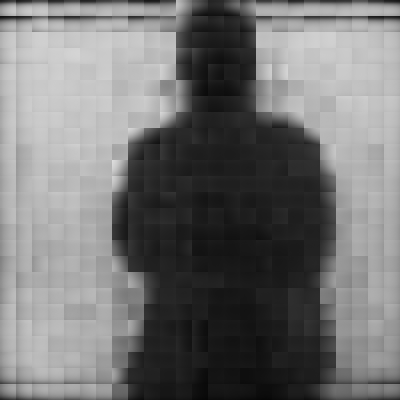

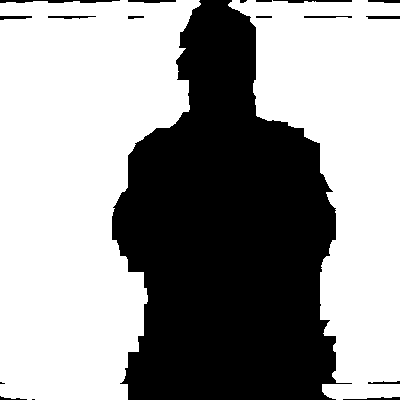

In [ ]:
#@title Inupt the prompt for segmentation
#Create masks for the parts of image to be identified
mask_prompt = "background" #@param{type:"string"}
mask_threshold = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
prompts = [mask_prompt]
mask_index = 0
transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),])
tensor_image = transform(source_image).unsqueeze(0)
print(tensor_image.shape)
with torch.no_grad():
  preds= model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]
processed_mask = torch.special.ndtr(preds[mask_index][0])
stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)
processed_mask = torch.special.ndtr(preds[mask_index][0])
processed_mask = processed_mask >= mask_threshold
processed_mask = processed_mask.numpy()
dilated_scale = 1 #@param {type:"slider", min:1, max:10, step:1}
stable_diffusion_mask = PIL.Image.fromarray(processed_mask)
if dilated_scale >1 :
  dilated_mask_cv = dilate_mask(processed_mask, kernel_size=5*dilated_scale, iterations=2)
  # 将OpenCV图像格式转换回PIL图像
  stable_diffusion_mask = Image.fromarray(dilated_mask_cv.astype(bool))
display(stable_diffusion_mask)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

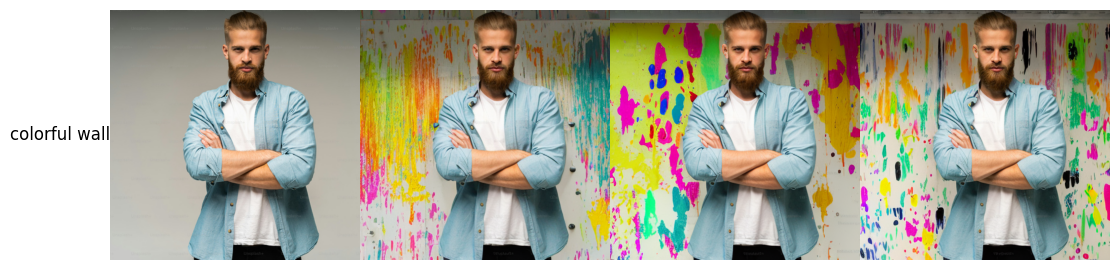

In [ ]:
#@title Generate inpainted images

num_inference_steps = 40 #@param {type:"slider", min:10, max:50, step:10}
guidance_scale = 17 #@param {type:"slider", min:1, max:20, step:1}
inpainting_prompt ="colorful wall" #@param{type:"string"}
sourceimage_index = 0 #@param {type:"slider", min:0, max:3, step:1}
my_source_image = source_image
if sourceimage_index > 0 and len(encoded_images)> 0:
  my_source_image = encoded_images[sourceimage_index]
encoded_images=[]
encoded_images.append(source_image)
for _ in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompt,
                     guidance_scale=guidance_scale,
                     num_inference_steps=num_inference_steps,
                    #  generator=generator,
                     image=my_source_image,
                     mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)
create_image_grid(encoded_images, [inpainting_prompt],(3,2))

#Implement with GUI

In [ ]:
#@title Generate inpainted images GUI
import ipywidgets as widgets
from IPython.display import display, clear_output

%cd $original_dir

encoded_images =[]
processed_mask = None
# CreateWidget
url_textbox = widgets.Text(description='Image URL:', style={'description_width': 'initial'},
        value = "https://plus.unsplash.com/premium_photo-1661329978374-fa980dadaff6?q=80&w=2940&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
width_textbox = widgets.IntText(description='Width:', value=400, style={'description_width': 'initial'})
height_textbox = widgets.IntText(description='Height:', value=400, style={'description_width': 'initial'})
load_button = widgets.Button(description='Load Image by URL')
upload_button = widgets.Button(description='Upload Image from disk')
source_output = widgets.Output()
mask_threshold_slider = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.1, description='Mask Threshold:')
mask_dilate_slider = widgets.IntSlider(value=1, min=1,max=5, step=1, description='Mask Dilate Scale:')

mask_textbox = widgets.Text(description='Mask prompt:', style={'description_width': 'initial'}, value="clothes")

# mask_button = widgets.Button(description='Mask Button', layout=widgets.Layout(visibility='hidden'))
mask_button = widgets.Button(description='Generate Mask')
mask_output = widgets.Output()

inpaint_button = widgets.Button(description='Generate Image')
save_button = widgets.Button(description='Save Images')
Image_output = widgets.Output()


num_inference_steps_slider = widgets.IntSlider(
    value=40, min=10, max=50, step=10,
    description='Inference Steps:',
    style={'description_width': 'initial'}
)


guidance_scale_slider = widgets.IntSlider(
    value=17, min=1, max=20, step=1,
    description='Guide Scale:',
    style={'description_width': 'initial'}
)


inpainting_prompt_input = widgets.Text(
    value='colorful wall',
    description='Prompt:',
    style={'description_width': 'initial'}
)


sourceimage_index_slider = widgets.IntSlider(
    value=-1, min=-1, max=3, step=1,
    description='Source Image Index:',
    style={'description_width': 'initial'}
)



# Show Image widget from PIL Image
def image_widget_from_pil(pil_img):
    with BytesIO() as f:
        pil_img.save(f, format='PNG')
        return widgets.Image(value=f.getvalue(), format='png')

# Callback function for button
def on_load_button_clicked(b):
    global source_image
    global target_width
    global target_height
    global segmentation_image
    with source_output:
        clear_output()
        try:
            source_image = load_image_from_url(url_textbox.value)
            width, height = source_image.size
            target_width = width_textbox.value
            target_height = height_textbox.value
            # print(f"Source image size:{source_image.size}")
            source_image = resize_and_crop(source_image, target_width, target_height)
            # print(f"Target image size:{source_image.size}")
            segmentation_image = asarray(source_image)
            display(source_image)


        except Exception as e:
            print(f"Error downloading the image: {e}")

def on_upload_button_click(b):
    global source_image
    global target_width
    global target_height
    global segmentation_image
    with source_output:
          source_image = load_image_from_upload()
          target_width = width_textbox.value
          target_height = height_textbox.value
          source_image = resize_and_crop(source_image, target_width, target_height)
          clear_output()
          segmentation_image = asarray(source_image)
          display(source_image)


def on_mask_button_clicked(b):
    global stable_diffusion_mask
    global processed_mask
    with mask_output:
        clear_output()
        tensor_image = transform(source_image).unsqueeze(0)
        mask_prompt = mask_textbox.value
        prompts = [mask_prompt]
        mask_threshold = mask_threshold_slider.value

        with torch.no_grad():
            preds= model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]
        processed_mask = torch.special.ndtr(preds[mask_index][0])
        processed_mask = processed_mask >= mask_threshold
        processed_mask = processed_mask.numpy()
        dilated_scale = mask_dilate_slider.value
        # stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
        stable_diffusion_mask = PIL.Image.fromarray(processed_mask)
        if dilated_scale >1 :
          dilated_mask_cv = dilate_mask(processed_mask, kernel_size=5*dilated_scale, iterations=2)
          stable_diffusion_mask = Image.fromarray(dilated_mask_cv.astype(bool))
        display(stable_diffusion_mask)

# def on_dilate_value_change(change):
#     global processed_mask
#     global stable_diffusion_mask
#     with mask_output:
#         clear_output()
#         dilated_scale = mask_dilate_slider.value
#         if dilated_scale >1 :
#           processed_mask = processed_mask >= mask_threshold
#           dilated_mask_cv = dilate_mask(processed_mask, kernel_size=5*dilated_scale, iterations=2)
#           stable_diffusion_mask = Image.fromarray(dilated_mask_cv.astype(bool))
#         display(stable_diffusion_mask)

# mask_dilate_slider.observe(on_dilate_value_change, names='value')

def on_inpaint_button_clicked(b):
    global stable_diffusion_mask
    global encoded_images
    with Image_output:
        my_source_image = source_image
        sourceimage_index = sourceimage_index_slider.value
        if sourceimage_index >= 0 and len(encoded_images)> 0:
          my_source_image = encoded_images[sourceimage_index]
        encoded_images=[]
        inpainting_prompt=inpainting_prompt_input.value
        encoded_images.append(my_source_image)
        for _ in range(num_images_per_prompt):
            image = pipe(prompt=inpainting_prompt,
                     guidance_scale=guidance_scale,
                     num_inference_steps=num_inference_steps,
                     image=my_source_image,
                     mask_image=stable_diffusion_mask).images[0]
            encoded_images.append(image)
        clear_output()
        create_image_grid(encoded_images, [inpainting_prompt],(3,2))

def on_save_button_clicked(b):
  with Image_output:
    if len(encoded_images)>0:
      output_path = 'inpaintoutput/'
      save_pil_images(encoded_images,output_path)
      print(f"Save files to{output_path}")

# save images to files
def save_pil_images(images, directory_path):
    import os
    start_index =0
    # Ensure the directory exists; if not, create it
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    else:
        # Count existing files in the directory to determine the starting index
        existing_files_count = len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])
        start_index = existing_files_count + 1

    # Iterate over the images and save each one
    for idx, image in enumerate(images, start=start_index):
        # Construct the file path with a sequential filename
        file_path = os.path.join(directory_path, f'output_{idx}.jpg')  # Assuming we want to save as JPG

        # Save the image
        image.save(file_path)

# Bind event to button
load_button.on_click(on_load_button_clicked)
upload_button.on_click(on_upload_button_click)
mask_button.on_click(on_mask_button_clicked)
inpaint_button.on_click(on_inpaint_button_clicked)
save_button.on_click(on_save_button_clicked)

# Create panel
vbox_load_input = widgets.HBox([url_textbox, width_textbox, height_textbox, load_button, upload_button])
vbox_mask_input = widgets.HBox([mask_textbox, mask_threshold_slider,mask_dilate_slider, mask_button])
vbox_load_result = widgets.HBox([source_output,mask_output])
# vbox_resize = widgets.VBox([width_textbox, height_textbox, resize_button, comparison_output])

vbox_inpaint_input = widgets.HBox([
    inpainting_prompt_input,
    num_inference_steps_slider,
    guidance_scale_slider,
    sourceimage_index_slider,
    inpaint_button,
    save_button
])


display(widgets.VBox([vbox_load_input, vbox_load_result,vbox_mask_input,vbox_inpaint_input,Image_output]))

/content
